# Self-Exciting process (Hawkes process)

For a review of self-exciting point processes and more please see https://arxiv.org/pdf/1507.02822.pdf.

Hear a Poisson point process's intensity, $\lambda(t)$, is conditionally dependent on past events.

Let the intensity be given by a constant background plus an exponential term:

$$\lambda(t) = \mu + \sum_{t_i < t}  \phi(t-t_i)$$

The average number of _daughters_ from an event is $\int_0^\infty \phi(t) \mathrm{d} t$ and is called the branching ratio. If the branching ratio is > 1 then there is non-zero probability of having infinite events spawned from a single event.

We'll let $\phi(t) = \alpha e^{-\beta t}$, where $\int_0^\infty \phi(t) \mathrm{d} t = \alpha/\beta \triangleq B$.

In [1]:
import pylab as plt
import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp, vmap

from jaxns import resample

tfpd = tfp.distributions

INFO[2023-06-15 15:25:49,435]: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO[2023-06-15 15:25:49,436]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-06-15 15:25:49,436]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-06-15 15:25:49,437]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
INFO[2023-06-15 15:25:49,438]: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
WARNING[2023-06-15 15:25:49,438]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
# Generate data

num_samples = 10

event_times = jnp.concatenate([jnp.linspace(0., 1., num_samples) ** 2,
                               2. + jnp.linspace(0., 1., num_samples) ** 2])

In [3]:
from jaxns import Prior, Model

# Build model
B = 2.0


def lam_t(mu, alpha, beta, t):
    dt = t[:, None] - event_times[None, :]
    # a-a, a-b
    phi = alpha * jnp.exp(-beta * jnp.where(dt > 0, dt, 0)) * jnp.where(dt > 0, 1, 0)
    lam = mu + jnp.sum(phi, axis=1)
    return lam


def log_likelihood(mu, alpha, beta):
    """
    Poisson likelihood.
    """
    lam = lam_t(mu, alpha, beta, event_times)
    Lam = mu + B * event_times.size
    return jnp.sum(jnp.log(lam)) - Lam


def prior_model():
    mu = yield Prior(tfpd.HalfCauchy(loc=0, scale=1.), name='mu')
    beta = yield Prior(tfpd.HalfNormal(num_samples), name='beta')
    alpha = yield Prior(tfpd.Uniform(0., B * beta), name='alpha')
    return mu, alpha, beta


model = Model(prior_model=prior_model, log_likelihood=log_likelihood)

model.sanity_check(random.PRNGKey(0), S=100)

INFO[2023-06-15 15:25:49,917]: Sanity check...
INFO[2023-06-15 15:25:50,355]: Sanity check passed


In [4]:
from jaxns import ExactNestedSampler, TerminationCondition

exact_ns = ExactNestedSampler(model=model, num_live_points=model.U_ndims * 100, max_samples=1e6)

termination_reason, state = exact_ns(random.PRNGKey(42), term_cond=TerminationCondition(live_evidence_frac=1e-4))
results = exact_ns.to_results(state, termination_reason)

2023-06-15 15:25:54.659479: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  reduce-window.15 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime.  XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2023-06-15 15:25:55.667745: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 2.008346906s
Constant folding an instruction is taking > 1s:

  reduce-window.15 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 60437
# samples: 3300
# slices: 16200.0
# slices / acceptance: 9.0
# likelihood evals / sample: 18.3
# likelihood evals / slice: 3.0
--------
logZ=5.37 +- 0.11
H=13000.0
ESS=802
--------
alpha: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
alpha: 12.6 +- 6.3 | 6.2 / 11.2 / 20.8 | 8.6 | 11.7
--------
beta: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
beta: 6.9 +- 3.3 | 3.4 / 6.2 / 11.4 | 4.3 | 5.9
--------
mu: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
mu: 9.0 +- 4.1 | 3.7 / 8.7 / 14.3 | 6.5 | 9.8
--------


WARNING[2023-06-15 15:26:14,605]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


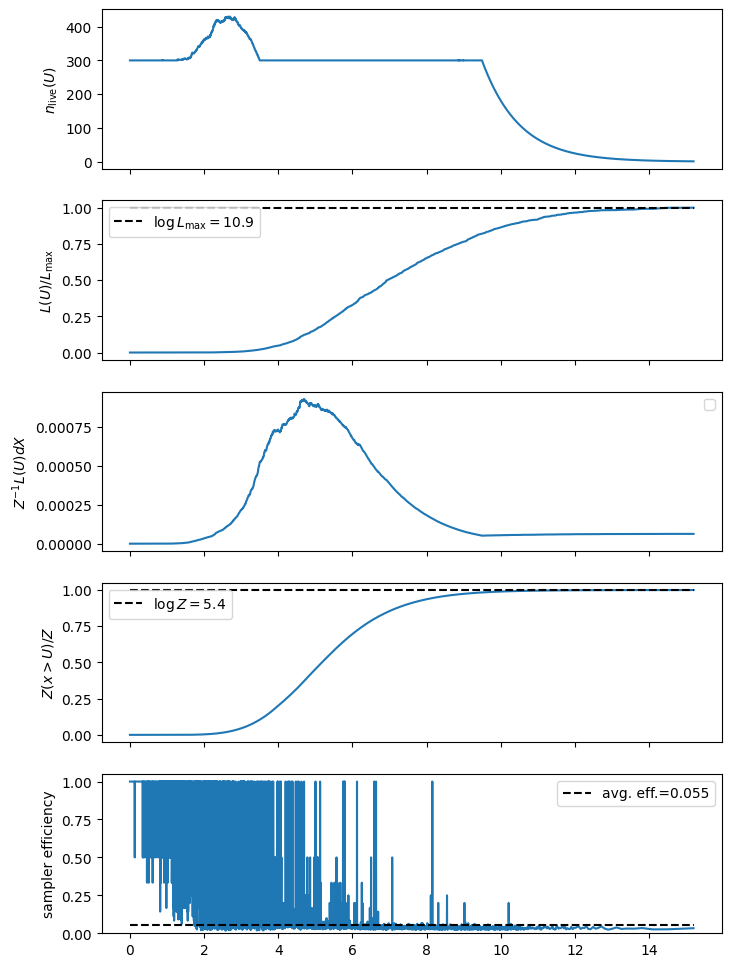

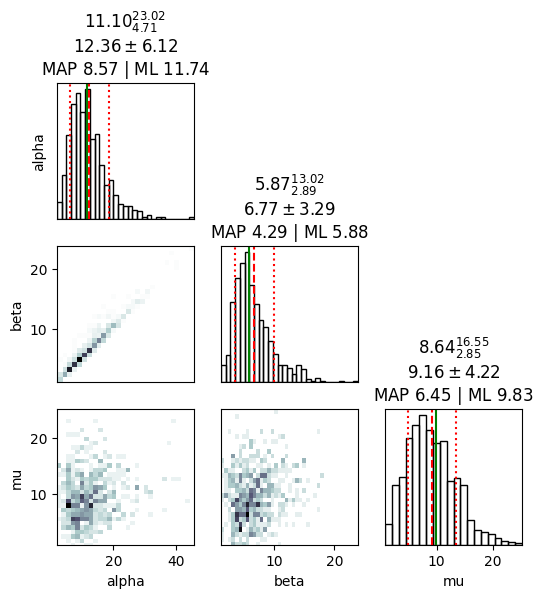

In [5]:
exact_ns.summary(results)
exact_ns.plot_diagnostics(results)
exact_ns.plot_cornerplot(results)

In [6]:
samples = resample(random.PRNGKey(42), results.samples, results.log_dp_mean, replace=True)
pred_times = jnp.linspace(0., 4., 100)
pred_lam = vmap(lambda mu, alpha, beta: lam_t(mu, alpha, beta, pred_times))(**samples)

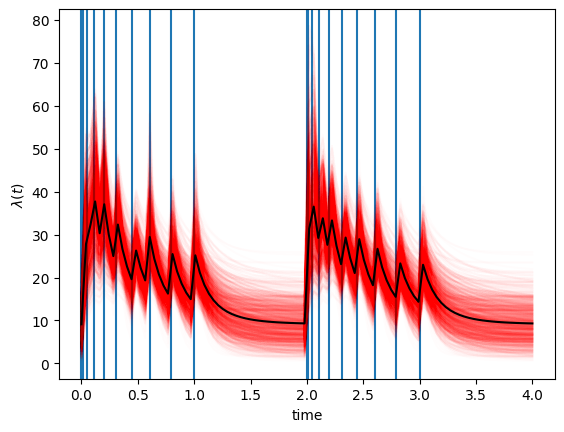

In [7]:
[plt.axvline(e) for e in event_times]
plt.plot(pred_times, pred_lam.T, c='red', alpha=0.01)
plt.plot(pred_times, pred_lam.mean(0), c='black')
plt.xlabel('time')
plt.ylabel(r'$\lambda(t)$')
plt.show()

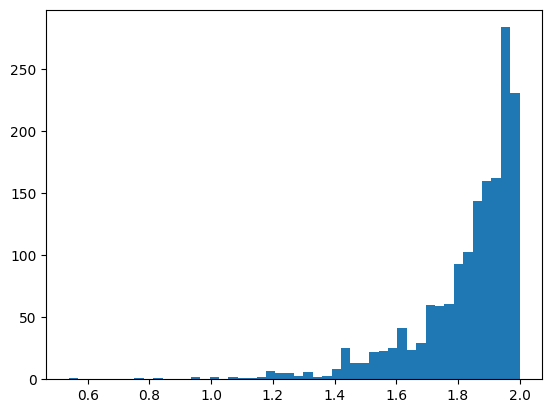

In [8]:
B = samples['alpha'] / samples['beta']
plt.hist(B, bins='auto')
plt.show()